In [1]:
%load_ext nb_black
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse

# sklearn/XGboost imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    classification_report,
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
cd

C:\Users\jonat


<IPython.core.display.Javascript object>

In [3]:
cd Desktop

ERROR:root:Cannot parse: 1:3: cd Desktop
Traceback (most recent call last):
  File "C:\Users\jonat\anaconda3\lib\site-packages\lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "C:\Users\jonat\anaconda3\lib\site-packages\lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "C:\Users\jonat\anaconda3\lib\site-packages\black.py", line 725, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "C:\Users\jonat\anaconda3\lib\site-packages\black.py", line 836, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:3: cd Desktop


C:\Users\jonat\Desktop


In [4]:
with sqlite3.connect("database.sqlite") as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes", con)


<IPython.core.display.Javascript object>

In [5]:
"""
Datasets I care about:
Matches  
team_attributes 


I need to figure out how to combine players and the teams. If i had more time/better understanding, I would combine. For now,
I'll just look at teams
"""

"\nDatasets I care about:\nMatches  \nteam_attributes \n\n\nI need to figure out how to combine players and the teams. If i had more time/better understanding, I would combine. For now,\nI'll just look at teams\n"

<IPython.core.display.Javascript object>

# Gonna check win loss split to make sure this data isn't super lopsided

In [6]:
won = matches["home_team_goal"] > matches["away_team_goal"]
loss = matches["home_team_goal"] < matches["away_team_goal"]
tie = matches["home_team_goal"] == matches["away_team_goal"]

<IPython.core.display.Javascript object>

In [7]:
tie

0         True
1         True
2        False
3        False
4        False
         ...  
25974    False
25975    False
25976    False
25977     True
25978    False
Length: 25979, dtype: bool

<IPython.core.display.Javascript object>

In [8]:
# 51.1%
won.value_counts()

False    14062
True     11917
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# 69.5%
tie.value_counts()

False    19383
True      6596
dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# 71.2%
print(loss.value_counts())

False    18513
True      7466
dtype: int64


<IPython.core.display.Javascript object>

# Well it seems that the distributions aren't too bad. I can stick with the team attributes for now.

In [11]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

<IPython.core.display.Javascript object>

In [12]:
for col in matches.columns:
    print(col)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

<IPython.core.display.Javascript object>

# Going through and dropping columns with an absolute value coorelation of over 50%. Also using my judgement that they aren't as similar as almost all goalkeeper skills

In [13]:
matches_corr = matches.corr()
matches_corr = matches_corr.reset_index().melt("index")
matches_corr["ABS"] = matches_corr["value"].abs()
matches_corr = matches_corr.sort_values(by="ABS", ascending=False)
matches_corr = matches_corr[matches_corr["index"] != matches_corr["variable"]]
matches_corr.head(90)

,index,variable,value,ABS
211,country_id,league_id,1.000000,1.000000
107,league_id,country_id,1.000000,1.000000
105,id,country_id,0.994503,0.994503
1,country_id,id,0.994503,0.994503
2,league_id,id,0.994503,0.994503
...,...,...,...,...
9449,BSA,PSA,0.982388,0.982388
10997,B365A,BSA,0.982051,0.982051
8189,BSA,B365A,0.982051,0.982051
8913,SJH,LBH,0.981914,0.981914


<IPython.core.display.Javascript object>

In [14]:
# country and league ID aren't that useful so I'm gonna drop those. No need so the correlations aren't important
ting = matches.drop(
    columns=[
        "id",
        "country_id",
        "league_id",
        "B365H",
        "B365D",
        "B365A",
        "BWH",
        "BWD",
        "BWA",
        "IWH",
        "IWD",
        "IWA",
        "LBH",
        "LBD",
        "LBA",
        "PSH",
        "PSD",
        "PSA",
        "WHH",
        "WHD",
        "WHA",
        "SJH",
        "SJD",
        "SJA",
        "VCH",
        "VCD",
        "VCA",
        "GBH",
        "GBD",
        "GBA",
        "BSH",
        "BSD",
        "BSA",
        "home_player_X1",
        "home_player_X2",
        "home_player_X3",
        "home_player_X4",
        "home_player_X5",
        "home_player_X6",
        "home_player_X7",
        "home_player_X8",
        "home_player_X9",
        "home_player_X10",
        "home_player_X11",
        "away_player_X1",
        "away_player_X2",
        "away_player_X3",
        "away_player_X4",
        "away_player_X5",
        "away_player_X6",
        "away_player_X7",
        "away_player_X8",
        "away_player_X9",
        "away_player_X10",
        "away_player_X11",
        "home_player_Y1",
        "home_player_Y2",
        "home_player_Y3",
        "home_player_Y4",
        "home_player_Y5",
        "home_player_Y6",
        "home_player_Y7",
        "home_player_Y8",
        "home_player_Y9",
        "home_player_Y10",
        "home_player_Y11",
        "away_player_Y1",
        "away_player_Y2",
        "away_player_Y3",
        "away_player_Y4",
        "away_player_Y5",
        "away_player_Y6",
        "away_player_Y7",
        "away_player_Y8",
        "away_player_Y9",
        "away_player_Y10",
        "away_player_Y11",
        "home_player_1",
        "home_player_2",
        "home_player_3",
        "home_player_4",
        "home_player_5",
        "home_player_6",
        "home_player_7",
        "home_player_8",
        "home_player_9",
        "home_player_10",
        "home_player_11",
        "away_player_1",
        "away_player_2",
        "away_player_3",
        "away_player_4",
        "away_player_5",
        "away_player_6",
        "away_player_7",
        "away_player_8",
        "away_player_9",
        "away_player_10",
        "away_player_11",
    ]
)
ting = ting.corr().reset_index().melt("index")
ting["ABS"] = ting["value"].abs()
ting = ting.sort_values(by="ABS", ascending=False)
ting = ting[ting["index"] != ting["variable"]]
ting.head(30)

,index,variable,value,ABS
8,home_team_api_id,match_api_id,0.090613,0.090613
13,match_api_id,home_team_api_id,0.090613,0.090613
9,away_team_api_id,match_api_id,0.090607,0.090607
19,match_api_id,away_team_api_id,0.090607,0.090607
29,away_team_goal,home_team_goal,-0.064099,0.064099
34,home_team_goal,away_team_goal,-0.064099,0.064099
11,away_team_goal,match_api_id,0.025996,0.025996
31,match_api_id,away_team_goal,0.025996,0.025996
16,home_team_goal,home_team_api_id,-0.015857,0.015857
26,home_team_api_id,home_team_goal,-0.015857,0.015857


<IPython.core.display.Javascript object>

# now that i've seen what matches look like, time to look at team attributes to see if there is anything I should drop before dropping.

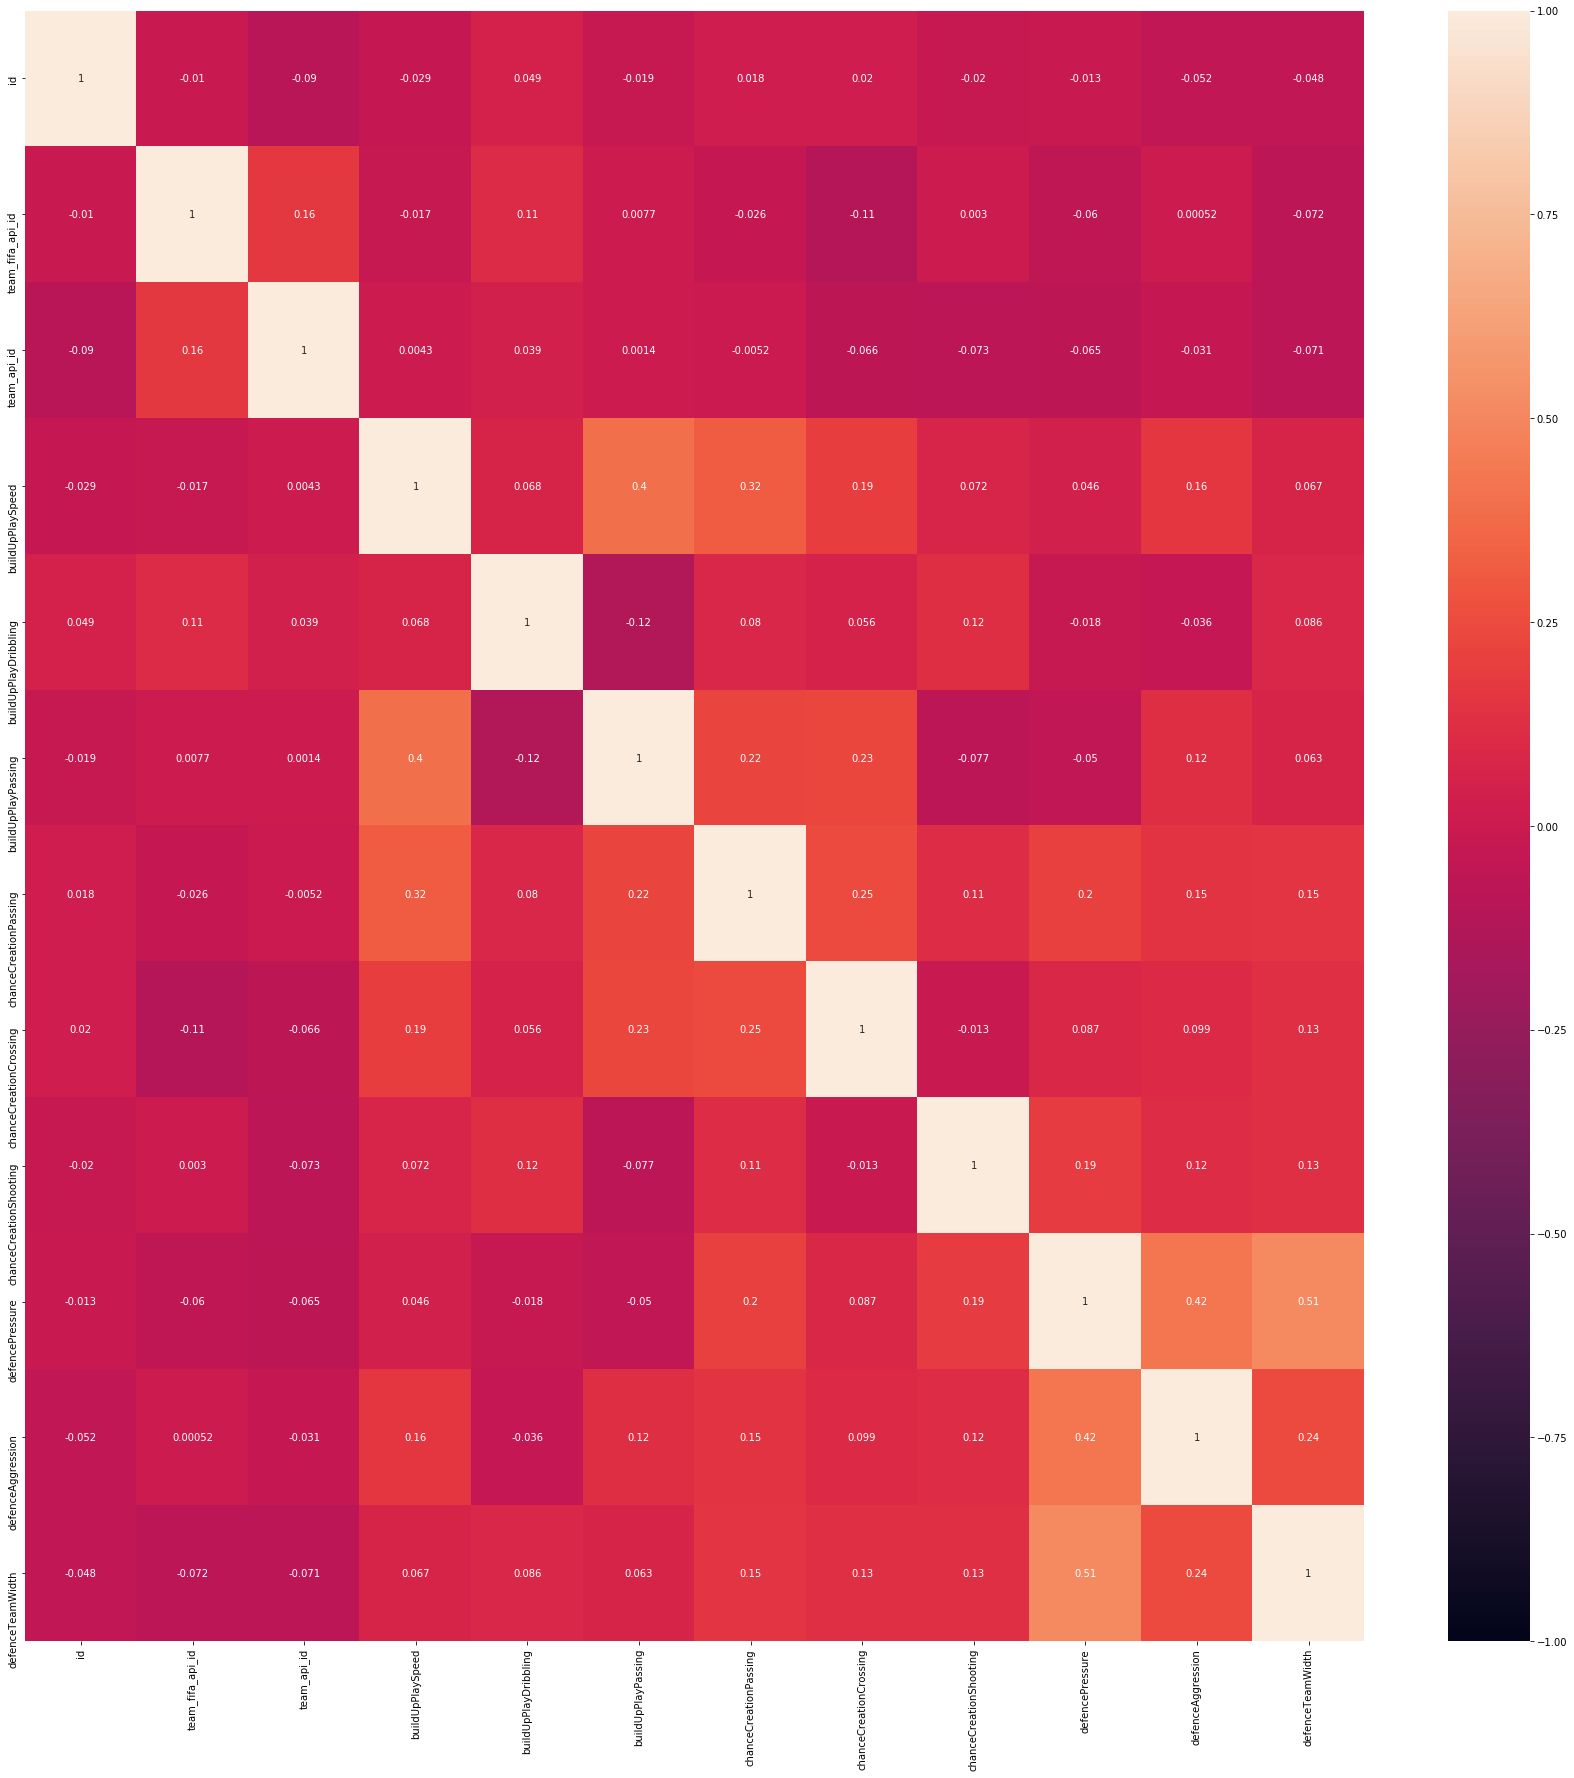

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(team_attributes.corr(), vmin=-1, vmax=1, annot=True, ax=ax)
plt.show()

In [16]:
# An argument could be made for pressure and width being similar, but that isn't necessarily true so I'm not dropping it
TA_corr = team_attributes.corr()
TA_corr = TA_corr.reset_index().melt("index")
TA_corr["ABS"] = TA_corr["value"].abs()
TA_corr = TA_corr.sort_values(by="ABS", ascending=False)
TA_corr = TA_corr[TA_corr["index"] != TA_corr["variable"]]
TA_corr.head(20)

,index,variable,value,ABS
141,defencePressure,defenceTeamWidth,0.508464,0.508464
119,defenceTeamWidth,defencePressure,0.508464,0.508464
129,defencePressure,defenceAggression,0.422493,0.422493
118,defenceAggression,defencePressure,0.422493,0.422493
41,buildUpPlayPassing,buildUpPlaySpeed,0.395506,0.395506
63,buildUpPlaySpeed,buildUpPlayPassing,0.395506,0.395506
42,chanceCreationPassing,buildUpPlaySpeed,0.319162,0.319162
75,buildUpPlaySpeed,chanceCreationPassing,0.319162,0.319162
90,chanceCreationPassing,chanceCreationCrossing,0.246528,0.246528
79,chanceCreationCrossing,chanceCreationPassing,0.246528,0.246528


<IPython.core.display.Javascript object>

# So after looking at the columns, I have deceided to drop the following columns due to clear leack of coorelation(player names/birthday/etc.), redundancy with other statistics (the bottom letters are betting site stats and I'm not presenting to Michael Jordan or Gretsky's wife so ignoring those as well).

In [17]:
drop_col=[
        "id",
        "country_id",
        "league_id",
        "B365H",
        "B365D",
        "B365A",
        "BWH",
        "BWD",
        "BWA",
        "IWH",
        "IWD",
        "IWA",
        "LBH",
        "LBD",
        "LBA",
        "PSH",
        "PSD",
        "PSA",
        "WHH",
        "WHD",
        "WHA",
        "SJH",
        "SJD",
        "SJA",
        "VCH",
        "VCD",
        "VCA",
        "GBH",
        "GBD",
        "GBA",
        "BSH",
        "BSD",
        "BSA",
        "home_player_X1",
        "home_player_X2",
        "home_player_X3",
        "home_player_X4",
        "home_player_X5",
        "home_player_X6",
        "home_player_X7",
        "home_player_X8",
        "home_player_X9",
        "home_player_X10",
        "home_player_X11",
        "away_player_X1",
        "away_player_X2",
        "away_player_X3",
        "away_player_X4",
        "away_player_X5",
        "away_player_X6",
        "away_player_X7",
        "away_player_X8",
        "away_player_X9",
        "away_player_X10",
        "away_player_X11",
        "home_player_Y1",
        "home_player_Y2",
        "home_player_Y3",
        "home_player_Y4",
        "home_player_Y5",
        "home_player_Y6",
        "home_player_Y7",
        "home_player_Y8",
        "home_player_Y9",
        "home_player_Y10",
        "home_player_Y11",
        "away_player_Y1",
        "away_player_Y2",
        "away_player_Y3",
        "away_player_Y4",
        "away_player_Y5",
        "away_player_Y6",
        "away_player_Y7",
        "away_player_Y8",
        "away_player_Y9",
        "away_player_Y10",
        "away_player_Y11",
        "home_player_1",
        "home_player_2",
        "home_player_3",
        "home_player_4",
        "home_player_5",
        "home_player_6",
        "home_player_7",
        "home_player_8",
        "home_player_9",
        "home_player_10",
        "home_player_11",
        "away_player_1",
        "away_player_2",
        "away_player_3",
        "away_player_4",
        "away_player_5",
        "away_player_6",
        "away_player_7",
        "away_player_8",
        "away_player_9",
        "away_player_10",
        "away_player_11",
    ]


<IPython.core.display.Javascript object>

# Now it's time to work on joining the stuff to one dataframe

In [18]:
mat_drop = matches.drop(columns=drop_col)

<IPython.core.display.Javascript object>

In [19]:
mat_drop

,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,None,None,None,None,None,None,None,None
1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,None,None,None,None,None,None,None,None
2,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,None,None,None,None,None,None,None,None
3,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,None,None,None,None,None,None,None,None
4,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,0,None,None,None,None,None,None,None,None
25975,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,2,None,None,None,None,None,None,None,None
25976,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,0,None,None,None,None,None,None,None,None
25977,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,0,None,None,None,None,None,None,None,None


<IPython.core.display.Javascript object>

In [20]:
type(team_attributes["date"])

pandas.core.series.Series

<IPython.core.display.Javascript object>

In [21]:
type(mat_drop["date"])

pandas.core.series.Series

<IPython.core.display.Javascript object>

In [22]:
mat_drop["date"].unique()

array(['2008-08-17 00:00:00', '2008-08-16 00:00:00',
       '2008-09-24 00:00:00', ..., '2016-05-22 00:00:00',
       '2016-05-25 00:00:00', '2015-08-13 00:00:00'], dtype=object)

<IPython.core.display.Javascript object>

In [23]:
team_attributes["date"].unique()

array(['2010-02-22 00:00:00', '2014-09-19 00:00:00',
       '2015-09-10 00:00:00', '2011-02-22 00:00:00',
       '2012-02-22 00:00:00', '2013-09-20 00:00:00'], dtype=object)

<IPython.core.display.Javascript object>

In [24]:
years = mat_drop["date"]
years[0][0:4]

'2008'

<IPython.core.display.Javascript object>

In [25]:
mat_drop["date"] = pd.to_datetime(mat_drop["date"])
mat_drop["year"] = mat_drop["date"].dt.year

<IPython.core.display.Javascript object>

In [26]:
team_attributes["date"] = pd.to_datetime(team_attributes["date"])
team_attributes["year"] = team_attributes["date"].dt.year

<IPython.core.display.Javascript object>

In [27]:
x = mat_drop.drop(
    columns=[
        "date",
        "season",
        "stage",
        "goal",
        "shoton",
        "shotoff",
        "foulcommit",
        "card",
        "cross",
        "corner",
        "possession",
    ]
)


x

,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,year
0,492473,9987,9993,1,1,2008
1,492474,10000,9994,0,0,2008
2,492475,9984,8635,0,3,2008
3,492476,9991,9998,5,0,2008
4,492477,7947,9985,1,3,2008
...,...,...,...,...,...,...
25974,1992091,10190,10191,1,0,2015
25975,1992092,9824,10199,1,2,2015
25976,1992093,9956,10179,2,0,2015
25977,1992094,7896,10243,0,0,2015


<IPython.core.display.Javascript object>

In [28]:
y = team_attributes.drop(columns=["id", "team_fifa_api_id", "date"])
y.sort_values(by="year", ascending=False)

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,year
1457,10000,54,Balanced,42.0,Normal,51,Mixed,Organised,47,Normal,...,Little,Organised,44,Medium,58,Press,37,Normal,Cover,2015
241,9858,42,Balanced,56.0,Normal,43,Mixed,Organised,41,Normal,...,Lots,Organised,41,Medium,52,Press,57,Normal,Cover,2015
253,8191,54,Balanced,32.0,Little,67,Long,Organised,72,Risky,...,Normal,Organised,63,Medium,62,Press,58,Normal,Cover,2015
828,8550,55,Balanced,48.0,Normal,49,Mixed,Organised,46,Normal,...,Normal,Organised,39,Medium,46,Press,42,Normal,Cover,2015
834,8549,60,Balanced,32.0,Little,46,Mixed,Organised,43,Normal,...,Normal,Organised,38,Medium,42,Press,42,Normal,Cover,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,8028,30,Slow,NaN,Little,45,Mixed,Organised,45,Normal,...,Lots,Organised,65,Medium,70,Double,60,Normal,Cover,2010
185,9911,50,Balanced,NaN,Little,65,Mixed,Organised,55,Normal,...,Normal,Organised,40,Medium,60,Press,40,Normal,Cover,2010
191,9857,65,Balanced,NaN,Little,55,Mixed,Organised,30,Safe,...,Normal,Organised,55,Medium,30,Contain,50,Normal,Offside Trap,2010
967,10167,30,Slow,NaN,Little,30,Short,Free Form,40,Normal,...,Lots,Free Form,45,Medium,30,Contain,70,Wide,Offside Trap,2010


<IPython.core.display.Javascript object>

In [29]:
home_teams = pd.DataFrame(
    data=mat_drop,
    columns=["match_api_id", "home_team_api_id", "home_team_goal", "year"],
)
home_teams = home_teams.rename(columns={"home_team_api_id": "team_api_id"})
home_teams

,match_api_id,team_api_id,home_team_goal,year
0,492473,9987,1,2008
1,492474,10000,0,2008
2,492475,9984,0,2008
3,492476,9991,5,2008
4,492477,7947,1,2008
...,...,...,...,...
25974,1992091,10190,1,2015
25975,1992092,9824,1,2015
25976,1992093,9956,2,2015
25977,1992094,7896,0,2015


<IPython.core.display.Javascript object>

In [30]:
away_teams = pd.DataFrame(
    data=mat_drop,
    columns=["match_api_id", "away_team_api_id", "away_team_goal", "year"],
)
away_teams = away_teams.rename(columns={"away_team_api_id": "team_api_id"})
away_teams

,match_api_id,team_api_id,away_team_goal,year
0,492473,9993,1,2008
1,492474,9994,0,2008
2,492475,8635,3,2008
3,492476,9998,0,2008
4,492477,9985,3,2008
...,...,...,...,...
25974,1992091,10191,0,2015
25975,1992092,10199,2,2015
25976,1992093,10179,0,2015
25977,1992094,10243,0,2015


<IPython.core.display.Javascript object>

In [31]:
away_teams = away_teams.merge(team_attributes, on=["team_api_id", "year"])
away_teams

,match_api_id,team_api_id,away_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,665626,8342,2,2010,319,231,2010-02-22,35,Balanced,NaN,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
1,665674,8342,0,2010,319,231,2010-02-22,35,Balanced,NaN,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
2,665700,8342,1,2010,319,231,2010-02-22,35,Balanced,NaN,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
3,665721,8342,1,2010,319,231,2010-02-22,35,Balanced,NaN,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
4,665737,8342,1,2010,319,231,2010-02-22,35,Balanced,NaN,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18809,1992135,10190,1,2015,1215,898,2015-09-10,52,Balanced,46.0,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18810,1992059,10190,0,2015,1215,898,2015-09-10,52,Balanced,46.0,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18811,1992073,10190,1,2015,1215,898,2015-09-10,52,Balanced,46.0,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18812,1992082,10190,0,2015,1215,898,2015-09-10,52,Balanced,46.0,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover


<IPython.core.display.Javascript object>

In [32]:
mat_drop[mat_drop["match_api_id"] == 665626]

,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,year
376,2009/2010,19,2010-02-03,665626,8635,8342,3,2,None,None,None,None,None,None,None,None,2010


<IPython.core.display.Javascript object>

In [33]:
team_attributes[team_attributes["team_api_id"] == 8342]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,year
318,319,231,8342,2010-02-22,35,Balanced,NaN,Little,40,Mixed,...,Normal,Organised,60,Medium,70,Double,70,Wide,Cover,2010
319,320,231,8342,2011-02-22,67,Fast,NaN,Little,47,Mixed,...,Normal,Free Form,57,Medium,44,Press,47,Normal,Cover,2011
320,321,231,8342,2012-02-22,64,Balanced,NaN,Little,54,Mixed,...,Normal,Organised,60,Medium,50,Press,52,Normal,Cover,2012
321,322,231,8342,2013-09-20,45,Balanced,NaN,Little,48,Mixed,...,Normal,Organised,43,Medium,59,Press,45,Normal,Cover,2013
322,323,231,8342,2014-09-19,42,Balanced,52.0,Normal,45,Mixed,...,Normal,Organised,51,Medium,50,Press,57,Normal,Cover,2014
323,324,231,8342,2015-09-10,42,Balanced,52.0,Normal,45,Mixed,...,Normal,Organised,51,Medium,50,Press,57,Normal,Cover,2015


<IPython.core.display.Javascript object>

# Now that I'm sure my merge merged the data frames correctly, I'm going to do the same for the home team, check for nulls and clean both up

In [34]:
home_teams = home_teams.merge(team_attributes, on=["team_api_id", "year"])
home_teams

,match_api_id,team_api_id,home_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,665626,8635,3,2010,46,229,2010-02-22,50,Balanced,NaN,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
1,665698,8635,1,2010,46,229,2010-02-22,50,Balanced,NaN,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
2,665729,8635,2,2010,46,229,2010-02-22,50,Balanced,NaN,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
3,665745,8635,2,2010,46,229,2010-02-22,50,Balanced,NaN,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
4,838473,8635,4,2010,46,229,2010-02-22,50,Balanced,NaN,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1992133,10179,1,2015,1168,110770,2015-09-10,61,Balanced,57.0,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18812,1992059,10179,1,2015,1168,110770,2015-09-10,61,Balanced,57.0,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18813,1992074,10179,3,2015,1168,110770,2015-09-10,61,Balanced,57.0,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18814,1992077,10179,1,2015,1168,110770,2015-09-10,61,Balanced,57.0,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover


<IPython.core.display.Javascript object>

In [35]:
# dang, why so many NA values
away_teams.isna().mean()

match_api_id                      0.000000
team_api_id                       0.000000
away_team_goal                    0.000000
year                              0.000000
id                                0.000000
team_fifa_api_id                  0.000000
date                              0.000000
buildUpPlaySpeed                  0.000000
buildUpPlaySpeedClass             0.000000
buildUpPlayDribbling              0.665302
buildUpPlayDribblingClass         0.000000
buildUpPlayPassing                0.000000
buildUpPlayPassingClass           0.000000
buildUpPlayPositioningClass       0.000000
chanceCreationPassing             0.000000
chanceCreationPassingClass        0.000000
chanceCreationCrossing            0.000000
chanceCreationCrossingClass       0.000000
chanceCreationShooting            0.000000
chanceCreationShootingClass       0.000000
chanceCreationPositioningClass    0.000000
defencePressure                   0.000000
defencePressureClass              0.000000
defenceAggr

<IPython.core.display.Javascript object>

In [36]:
away_teams["buildUpPlayDribbling"].value_counts()

52.0    409
55.0    348
48.0    319
49.0    298
51.0    264
50.0    254
47.0    240
53.0    233
42.0    218
46.0    216
45.0    214
54.0    214
40.0    211
35.0    206
41.0    203
56.0    196
43.0    143
36.0    136
58.0    122
32.0    113
69.0    105
60.0    104
34.0    101
62.0    100
61.0     99
33.0     99
70.0     98
59.0     97
37.0     95
44.0     90
65.0     89
39.0     78
57.0     65
66.0     62
71.0     55
29.0     55
38.0     51
67.0     41
64.0     40
24.0     36
63.0     36
31.0     30
30.0     25
27.0     21
68.0     20
77.0     19
74.0     19
28.0     10
Name: buildUpPlayDribbling, dtype: int64

<IPython.core.display.Javascript object>

In [37]:
away_teams["buildUpPlayDribblingClass"].value_counts()

Little    12906
Normal     5551
Lots        357
Name: buildUpPlayDribblingClass, dtype: int64

<IPython.core.display.Javascript object>

# 66% is a ton of missing data. Rather than trying to fill in the missing data, I'm going to drop it since it would be more fake than real. It might lead to discoveries but that is something that could be explored in another passthrough. Make sure hometeams only has that issue then deal with it the same way too

In [38]:
home_teams.isna().mean()

match_api_id                      0.000000
team_api_id                       0.000000
home_team_goal                    0.000000
year                              0.000000
id                                0.000000
team_fifa_api_id                  0.000000
date                              0.000000
buildUpPlaySpeed                  0.000000
buildUpPlaySpeedClass             0.000000
buildUpPlayDribbling              0.665444
buildUpPlayDribblingClass         0.000000
buildUpPlayPassing                0.000000
buildUpPlayPassingClass           0.000000
buildUpPlayPositioningClass       0.000000
chanceCreationPassing             0.000000
chanceCreationPassingClass        0.000000
chanceCreationCrossing            0.000000
chanceCreationCrossingClass       0.000000
chanceCreationShooting            0.000000
chanceCreationShootingClass       0.000000
chanceCreationPositioningClass    0.000000
defencePressure                   0.000000
defencePressureClass              0.000000
defenceAggr

<IPython.core.display.Javascript object>

In [39]:
home_teams = home_teams.drop(columns="buildUpPlayDribbling")
away_teams = away_teams.drop(columns="buildUpPlayDribbling")

<IPython.core.display.Javascript object>

In [40]:
# Let's explore these class columns values to see what they're about
away_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18814 entries, 0 to 18813
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   match_api_id                    18814 non-null  int64         
 1   team_api_id                     18814 non-null  int64         
 2   away_team_goal                  18814 non-null  int64         
 3   year                            18814 non-null  int64         
 4   id                              18814 non-null  int64         
 5   team_fifa_api_id                18814 non-null  int64         
 6   date                            18814 non-null  datetime64[ns]
 7   buildUpPlaySpeed                18814 non-null  int64         
 8   buildUpPlaySpeedClass           18814 non-null  object        
 9   buildUpPlayDribblingClass       18814 non-null  object        
 10  buildUpPlayPassing              18814 non-null  int64         
 11  bu

<IPython.core.display.Javascript object>

In [41]:
away_teams

,match_api_id,team_api_id,away_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,665626,8342,2,2010,319,231,2010-02-22,35,Balanced,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
1,665674,8342,0,2010,319,231,2010-02-22,35,Balanced,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
2,665700,8342,1,2010,319,231,2010-02-22,35,Balanced,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
3,665721,8342,1,2010,319,231,2010-02-22,35,Balanced,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
4,665737,8342,1,2010,319,231,2010-02-22,35,Balanced,Little,...,45,Normal,Organised,60,Medium,70,Double,70,Wide,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18809,1992135,10190,1,2015,1215,898,2015-09-10,52,Balanced,Normal,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18810,1992059,10190,0,2015,1215,898,2015-09-10,52,Balanced,Normal,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18811,1992073,10190,1,2015,1215,898,2015-09-10,52,Balanced,Normal,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover
18812,1992082,10190,0,2015,1215,898,2015-09-10,52,Balanced,Normal,...,37,Normal,Organised,40,Medium,36,Press,52,Normal,Cover


<IPython.core.display.Javascript object>

In [42]:
home_teams

,match_api_id,team_api_id,home_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,665626,8635,3,2010,46,229,2010-02-22,50,Balanced,Little,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
1,665698,8635,1,2010,46,229,2010-02-22,50,Balanced,Little,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
2,665729,8635,2,2010,46,229,2010-02-22,50,Balanced,Little,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
3,665745,8635,2,2010,46,229,2010-02-22,50,Balanced,Little,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
4,838473,8635,4,2010,46,229,2010-02-22,50,Balanced,Little,...,60,Normal,Organised,70,High,50,Press,70,Wide,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1992133,10179,1,2015,1168,110770,2015-09-10,61,Balanced,Normal,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18812,1992059,10179,1,2015,1168,110770,2015-09-10,61,Balanced,Normal,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18813,1992074,10179,3,2015,1168,110770,2015-09-10,61,Balanced,Normal,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover
18814,1992077,10179,1,2015,1168,110770,2015-09-10,61,Balanced,Normal,...,53,Normal,Organised,45,Medium,47,Press,54,Normal,Cover


<IPython.core.display.Javascript object>

In [43]:
obj_cols = away_teams.select_dtypes("object").columns
obj_cols

Index(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassingClass', 'chanceCreationCrossingClass',
       'chanceCreationShootingClass', 'chanceCreationPositioningClass',
       'defencePressureClass', 'defenceAggressionClass',
       'defenceTeamWidthClass', 'defenceDefenderLineClass'],
      dtype='object')

<IPython.core.display.Javascript object>

In [44]:
# a lot of these look p different. I need dummies to help me compare
away_teams["defenceAggressionClass"].value_counts()

Press      16368
Double      1328
Contain     1118
Name: defenceAggressionClass, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
away_teams = pd.get_dummies(away_teams, columns=obj_cols, drop_first=True)
away_teams

,match_api_id,team_api_id,away_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,...,chanceCreationShootingClass_Lots,chanceCreationShootingClass_Normal,chanceCreationPositioningClass_Organised,defencePressureClass_High,defencePressureClass_Medium,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Offside Trap
0,665626,8342,2,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,1,0,0,1,0
1,665674,8342,0,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,1,0,0,1,0
2,665700,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,1,0,0,1,0
3,665721,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,1,0,0,1,0
4,665737,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18809,1992135,10190,1,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18810,1992059,10190,0,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18811,1992073,10190,1,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18812,1992082,10190,0,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0


<IPython.core.display.Javascript object>

In [46]:
home_teams = pd.get_dummies(home_teams, columns=obj_cols, drop_first=True)
home_teams

,match_api_id,team_api_id,home_team_goal,year,id,team_fifa_api_id,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,...,chanceCreationShootingClass_Lots,chanceCreationShootingClass_Normal,chanceCreationPositioningClass_Organised,defencePressureClass_High,defencePressureClass_Medium,defenceAggressionClass_Double,defenceAggressionClass_Press,defenceTeamWidthClass_Normal,defenceTeamWidthClass_Wide,defenceDefenderLineClass_Offside Trap
0,665626,8635,3,2010,46,229,2010-02-22,50,35,70,...,0,1,1,1,0,0,1,0,1,0
1,665698,8635,1,2010,46,229,2010-02-22,50,35,70,...,0,1,1,1,0,0,1,0,1,0
2,665729,8635,2,2010,46,229,2010-02-22,50,35,70,...,0,1,1,1,0,0,1,0,1,0
3,665745,8635,2,2010,46,229,2010-02-22,50,35,70,...,0,1,1,1,0,0,1,0,1,0
4,838473,8635,4,2010,46,229,2010-02-22,50,35,70,...,0,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18811,1992133,10179,1,2015,1168,110770,2015-09-10,61,37,62,...,0,1,1,0,1,0,1,1,0,0
18812,1992059,10179,1,2015,1168,110770,2015-09-10,61,37,62,...,0,1,1,0,1,0,1,1,0,0
18813,1992074,10179,3,2015,1168,110770,2015-09-10,61,37,62,...,0,1,1,0,1,0,1,1,0,0
18814,1992077,10179,1,2015,1168,110770,2015-09-10,61,37,62,...,0,1,1,0,1,0,1,1,0,0


<IPython.core.display.Javascript object>

In [47]:
home_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18816 entries, 0 to 18815
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   match_api_id                              18816 non-null  int64         
 1   team_api_id                               18816 non-null  int64         
 2   home_team_goal                            18816 non-null  int64         
 3   year                                      18816 non-null  int64         
 4   id                                        18816 non-null  int64         
 5   team_fifa_api_id                          18816 non-null  int64         
 6   date                                      18816 non-null  datetime64[ns]
 7   buildUpPlaySpeed                          18816 non-null  int64         
 8   buildUpPlayPassing                        18816 non-null  int64         
 9   chanceCreationPassing       

<IPython.core.display.Javascript object>

In [48]:
away_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18814 entries, 0 to 18813
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   match_api_id                              18814 non-null  int64         
 1   team_api_id                               18814 non-null  int64         
 2   away_team_goal                            18814 non-null  int64         
 3   year                                      18814 non-null  int64         
 4   id                                        18814 non-null  int64         
 5   team_fifa_api_id                          18814 non-null  int64         
 6   date                                      18814 non-null  datetime64[ns]
 7   buildUpPlaySpeed                          18814 non-null  int64         
 8   buildUpPlayPassing                        18814 non-null  int64         
 9   chanceCreationPassing       

<IPython.core.display.Javascript object>

# The difference of two games I don't think is super important in the big scheme of things

In [49]:
away_teams = away_teams.add_prefix("Away ")
home_teams = home_teams.add_prefix("Home ")

<IPython.core.display.Javascript object>

In [50]:
away_teams = away_teams.rename(
    columns={"Away date": "date", "Away match_api_id": "match_api_id"}
)
home_teams = home_teams.rename(
    columns={"Home date": "date", "Home match_api_id": "match_api_id"}
)

<IPython.core.display.Javascript object>

In [51]:
test = away_teams.merge(home_teams, on=["match_api_id"])
test

,match_api_id,Away team_api_id,Away away_team_goal,Away year,Away id,Away team_fifa_api_id,date_x,Away buildUpPlaySpeed,Away buildUpPlayPassing,Away chanceCreationPassing,...,Home chanceCreationShootingClass_Lots,Home chanceCreationShootingClass_Normal,Home chanceCreationPositioningClass_Organised,Home defencePressureClass_High,Home defencePressureClass_Medium,Home defenceAggressionClass_Double,Home defenceAggressionClass_Press,Home defenceTeamWidthClass_Normal,Home defenceTeamWidthClass_Wide,Home defenceDefenderLineClass_Offside Trap
0,665626,8342,2,2010,319,231,2010-02-22,35,40,45,...,0,1,1,1,0,0,1,0,1,0
1,665674,8342,0,2010,319,231,2010-02-22,35,40,45,...,0,1,1,1,0,0,1,0,1,0
2,665700,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,1,0,0,1,0,1,0
3,665721,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,0,1,1,0,0
4,665737,8342,1,2010,319,231,2010-02-22,35,40,45,...,0,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18238,1992135,10190,1,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18239,1992059,10190,0,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18240,1992073,10190,1,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,1,1,0,0
18241,1992082,10190,0,2015,1215,898,2015-09-10,52,48,39,...,0,1,1,0,1,0,0,1,0,0


<IPython.core.display.Javascript object>

In [52]:
test[test["match_api_id"] == 665626]["Home team_api_id"]

0    8635
Name: Home team_api_id, dtype: int64

<IPython.core.display.Javascript object>

In [53]:
matches[matches["match_api_id"] == 665626]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
376,377,1,1,2009/2010,19,2010-02-03 00:00:00,665626,8635,8342,3,...,4.75,1.67,3.6,4.5,1.72,3.4,4.5,1.73,3.4,4.2


<IPython.core.display.Javascript object>

# After confirming a few rows, I'm going to rename test, check, nulls, then make a goals column to start predicting goals. Negative goals means the away team has more. Positive means the home team has more

In [54]:
# AYYYYYYYY we have no NaNs! Let's start looking at reducing some features to make this even more selective
soccer = test.copy()
soccer.isna().mean().sort_values(ascending=False)

Home defenceDefenderLineClass_Offside Trap    0.0
Away chanceCreationCrossingClass_Normal       0.0
Away buildUpPlayPassingClass_Mixed            0.0
Away buildUpPlayPassingClass_Short            0.0
Away buildUpPlayPositioningClass_Organised    0.0
                                             ... 
Home defencePressure                          0.0
Home defenceAggression                        0.0
Home defenceTeamWidth                         0.0
Home buildUpPlaySpeedClass_Fast               0.0
match_api_id                                  0.0
Length: 71, dtype: float64

<IPython.core.display.Javascript object>

In [55]:
for col in soccer.columns:
    print(col)

match_api_id
Away team_api_id
Away away_team_goal
Away year
Away id
Away team_fifa_api_id
date_x
Away buildUpPlaySpeed
Away buildUpPlayPassing
Away chanceCreationPassing
Away chanceCreationCrossing
Away chanceCreationShooting
Away defencePressure
Away defenceAggression
Away defenceTeamWidth
Away buildUpPlaySpeedClass_Fast
Away buildUpPlaySpeedClass_Slow
Away buildUpPlayDribblingClass_Lots
Away buildUpPlayDribblingClass_Normal
Away buildUpPlayPassingClass_Mixed
Away buildUpPlayPassingClass_Short
Away buildUpPlayPositioningClass_Organised
Away chanceCreationPassingClass_Risky
Away chanceCreationPassingClass_Safe
Away chanceCreationCrossingClass_Lots
Away chanceCreationCrossingClass_Normal
Away chanceCreationShootingClass_Lots
Away chanceCreationShootingClass_Normal
Away chanceCreationPositioningClass_Organised
Away defencePressureClass_High
Away defencePressureClass_Medium
Away defenceAggressionClass_Double
Away defenceAggressionClass_Press
Away defenceTeamWidthClass_Normal
Away defenceT

<IPython.core.display.Javascript object>

In [56]:
soccer["goals"] = soccer["Home home_team_goal"] - soccer["Away away_team_goal"]
soccer["goals"].value_counts()

 0     4628
 1     3862
-1     2862
 2     2557
-2     1483
 3     1182
-3      590
 4      532
-4      214
 5      176
-5       62
 6       46
 7       17
-6       16
 8        7
-7        5
-8        2
 10       1
 9        1
Name: goals, dtype: int64

<IPython.core.display.Javascript object>

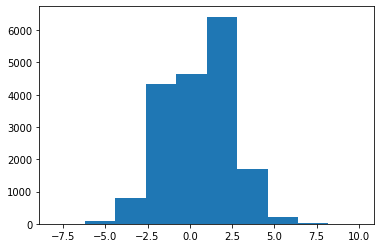

<IPython.core.display.Javascript object>

In [57]:
# pretty normal. Outliers shouldn't mess me up too much
plt.hist(soccer["goals"])
plt.show()

In [58]:
for col in soccer:
    print(col)

match_api_id
Away team_api_id
Away away_team_goal
Away year
Away id
Away team_fifa_api_id
date_x
Away buildUpPlaySpeed
Away buildUpPlayPassing
Away chanceCreationPassing
Away chanceCreationCrossing
Away chanceCreationShooting
Away defencePressure
Away defenceAggression
Away defenceTeamWidth
Away buildUpPlaySpeedClass_Fast
Away buildUpPlaySpeedClass_Slow
Away buildUpPlayDribblingClass_Lots
Away buildUpPlayDribblingClass_Normal
Away buildUpPlayPassingClass_Mixed
Away buildUpPlayPassingClass_Short
Away buildUpPlayPositioningClass_Organised
Away chanceCreationPassingClass_Risky
Away chanceCreationPassingClass_Safe
Away chanceCreationCrossingClass_Lots
Away chanceCreationCrossingClass_Normal
Away chanceCreationShootingClass_Lots
Away chanceCreationShootingClass_Normal
Away chanceCreationPositioningClass_Organised
Away defencePressureClass_High
Away defencePressureClass_Medium
Away defenceAggressionClass_Double
Away defenceAggressionClass_Press
Away defenceTeamWidthClass_Normal
Away defenceT

<IPython.core.display.Javascript object>

In [59]:
soccer = soccer.drop(
    columns=[
        "date_x",
        "date_y",
        "Home year",
        "Away away_team_goal",
        "Home home_team_goal",
    ]
)

<IPython.core.display.Javascript object>

In [60]:
soccer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18243 entries, 0 to 18242
Data columns (total 67 columns):
 #   Column                                         Non-Null Count  Dtype
---  ------                                         --------------  -----
 0   match_api_id                                   18243 non-null  int64
 1   Away team_api_id                               18243 non-null  int64
 2   Away year                                      18243 non-null  int64
 3   Away id                                        18243 non-null  int64
 4   Away team_fifa_api_id                          18243 non-null  int64
 5   Away buildUpPlaySpeed                          18243 non-null  int64
 6   Away buildUpPlayPassing                        18243 non-null  int64
 7   Away chanceCreationPassing                     18243 non-null  int64
 8   Away chanceCreationCrossing                    18243 non-null  int64
 9   Away chanceCreationShooting                    18243 non-null  int64
 10

<IPython.core.display.Javascript object>

# Alright. Check VIF for multicoliniarity, then gonna check features noise levels

In [61]:
# Gonna keep this here in case I need to mess with stuff again


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [62]:
X = soccer.drop(columns="goals")
y = soccer["goals"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

<IPython.core.display.Javascript object>

# Now I'll actually check OLS and VIF

In [63]:
# dang, so overfit
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     17.88
Date:                Wed, 22 Apr 2020   Prob (F-statistic):          7.77e-195
Time:                        14:39:39   Log-Likelihood:                -28566.
No. Observations:               14594   AIC:                         5.727e+04
Df Residuals:                   14527   BIC:                         5.778e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                           -26.7125     65.873     -0.406      0.685    -155.832     102.407
match_api_id                                  -7.985e-08   1.27e-07     -0.630      0.529   -3.28e-07    1.69e-07
Away team_api_id                                1.53e-06   1.37e-06      1.113      0.266   -1.16e-06    4.22e-06
Away year                                         0.0135      0.033      0.410      0.681      -0.051       0.078
Away id                                           0.0002   3.42e-05      4.740      0.000    9.51e-05       0.000
Away team_fifa_api_id                          2.673e-06   4.02e-07      6.650      0.000    1.89e-06    3.46e-06
Away buildUpPlaySpeed                            -0.0030      0.002     -1.547      0.122      -0.007       0.001
Away buildUpPlayPassing                           0.0064      0.002      3.309      0.001       0.003       0.010
Away chanceCreationPassing                        0.0030      0.002      1.459      0.145      -0.001       0.007
Away chanceCreationCrossing                      -0.0060      0.002     -3.148      0.002      -0.010      -0.002
Away chanceCreationShooting                      -0.0030      0.002     -1.494      0.135      -0.007       0.001
Away defencePressure                             -0.0084      0.002     -3.744      0.000      -0.013      -0.004
Away defenceAggression                           -0.0062      0.002     -2.842      0.004      -0.011      -0.002
Away defenceTeamWidth                             0.0018      0.002      0.830      0.406      -0.002       0.006
Away buildUpPlaySpeedClass_Fast                   0.0091      0.057      0.162      0.871      -0.102       0.120
Away buildUpPlaySpeedClass_Slow                  -0.0452      0.076     -0.596      0.551      -0.194       0.103
Away buildUpPlayDribblingClass_Lots              -0.4166      0.130     -3.204      0.001      -0.672      -0.162
Away buildUpPlayDribblingClass_Normal            -0.1469      0.081     -1.806      0.071      -0.306       0.013
Away buildUpPlayPassingClass_Mixed               -0.0299      0.075     -0.401      0.688      -0.176       0.116
Away buildUpPlayPassingClass_Short               -0.1396      0.109     -1.277      0.202      -0.354       0.075
Away buildUpPlayPositioningClass_Organised        0.3957      0.065      6.077      0.000       0.268       0.523
Away chanceCreationPassingClass_Risky            -0.1198      0.059     -2.044      0.041      -0.235      -0.005
Away chanceCreationPassingClass_Safe              0.1797      0.089      2.010      0.044       0.004       0.355
Away chanceCreationCrossingClass_Lots             0.1843      0.118      1.569      0.117      -0.046       0.415
Away 

<IPython.core.display.Javascript object>

In [64]:
aways = soccer.columns.str.contains("Away")
true = [
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
]
len(true)

35

<IPython.core.display.Javascript object>

In [65]:
home_soccer = soccer.drop(columns=soccer.columns[1:35])

<IPython.core.display.Javascript object>

In [66]:
# Now we're gonna run models with both only home data and all data to see if the away team data does indeed lead to better predictions

HX = home_soccer.drop(columns="goals")
hy = home_soccer["goals"]


HX_train, HX_test, hy_train, hy_test = train_test_split(
    HX, hy, test_size=0.2, random_state=69
)

<IPython.core.display.Javascript object>

In [67]:
# I mean it isn't as overfit which is nice... Going to see what
HX_train_const = sm.add_constant(HX_train)
lm = sm.OLS(hy_train, HX_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     16.94
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           4.11e-92
Time:                        14:39:39   Log-Likelihood:                -28869.
No. Observations:               14594   AIC:                         5.780e+04
Df Residuals:                   14561   BIC:                         5.806e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.7196      0.276      2.609      0.009       0.179       1.260
match_api_id                                   4.761e-09   6.79e-08      0.070      0.944   -1.28e-07    1.38e-07
Home id                                          -0.0001   3.49e-05     -3.772      0.000      -0.000   -6.33e-05
Home team_fifa_api_id                         -2.425e-06   4.01e-07     -6.054      0.000   -3.21e-06   -1.64e-06
Home buildUpPlaySpeed                            -0.0037      0.002     -1.894      0.058      -0.008       0.000
Home buildUpPlayPassing                          -0.0035      0.002     -1.801      0.072      -0.007       0.000
Home chanceCreationPassing                        0.0002      0.002      0.074      0.941      -0.004       0.004
Home chanceCreationCrossing                       0.0068      0.002      3.505      0.000       0.003       0.011
Home chanceCreationShooting                       0.0002      0.002      0.119      0.905      -0.004       0.004
Home defencePressure                              0.0097      0.002      4.291      0.000       0.005       0.014
Home defenceAggression                            0.0036      0.002      1.610      0.107      -0.001       0.008
Home defenceTeamWidth                             0.0039      0.002      1.779      0.075      -0.000       0.008
Home buildUpPlaySpeedClass_Fast                   0.1745      0.057      3.041      0.002       0.062       0.287
Home buildUpPlaySpeedClass_Slow                   0.0637      0.076      0.844      0.399      -0.084       0.212
Home buildUpPlayDribblingClass_Lots              -0.0228      0.117     -0.194      0.846      -0.253       0.207
Home buildUpPlayDribblingClass_Normal             0.0317      0.053      0.598      0.550      -0.072       0.136
Home buildUpPlayPassingClass_Mixed                0.1300      0.075      1.729      0.084      -0.017       0.277
Home buildUpPlayPassingClass_Short                0.1210      0.110      1.095      0.273      -0.096       0.338
Home buildUpPlayPositioningClass_Organised       -0.3858      0.065     -5.896      0.000      -0.514      -0.258
Home chanceCreationPassingClass_Risky             0.0899      0.060      1.498      0.134      -0.028       0.208
Home chanceCreationPassingClass_Safe              0.0555      0.091      0.613      0.540      -0.122       0.233
Home chanceCreationCrossingClass_Lots            -0.4025      0.121     -3.322      0.001      -0.640      -0.165
Home chanceCreationCrossingClass_Normal          -0.3354      0.096     -3.500      0.000      -0.523      -0.148
Home chanceCreationShootingClass_Lots             0.0982      0.125      0.784      0.433      -0.147       0.344
Home 

<IPython.core.display.Javascript object>

In [68]:
lr_bsl = LogisticRegression()
lr_fitted = lr_bsl.fit(HX_train, hy_train)

<IPython.core.display.Javascript object>

In [69]:
# That is a pretty trash score ngl Let's try it with the regular ones
Htrain_score = lr_fitted.score(HX_train, hy_train)
Htest_score = lr_fitted.score(HX_test, hy_test)


print(f"train_score: {Htrain_score}")
print(f"test_score: {Htest_score}")

train_score: 0.2515417294778676
test_score: 0.2622636338722938


<IPython.core.display.Javascript object>

In [70]:
r_fitted = lr_bsl.fit(X_train, y_train)
train_score = lr_fitted.score(X_train, y_train)
test_score = lr_fitted.score(X_test, y_test)


print(f"train_score: {train_score}")
print(f"test_score: {test_score}")
print(0.26253768155659085 - 0.2622636338722938)

train_score: 0.2514046868576127
test_score: 0.26253768155659085
0.00027404768429706294


<IPython.core.display.Javascript object>

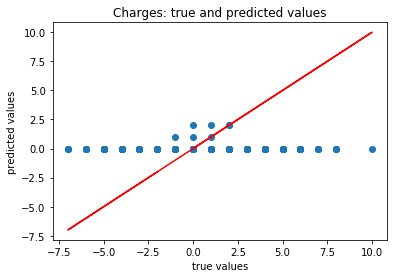

Mean absolute error of the prediction is: 1.3450260345300082
Mean squared error of the prediction is: 3.327486982734996
Root mean squared error of the prediction is: 1.824140066643731
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [71]:
y_preds = r_fitted.predict(X_test)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds) / y_test)) * 100
    )
)

# Well it seems like logistic regression is a pretty trash model. 
# I'm gonna check a few more models

In [72]:
# Check regularization models

<IPython.core.display.Javascript object>

In [73]:
# lasso seems pretty overfit imo
alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(HX_train, hy_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(HX_train)
y_preds_test = lasso_cv.predict(HX_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        lasso_cv.score(HX_train, hy_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(lasso_cv.score(HX_test, hy_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(hy_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(hy_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((hy_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 0.001
R-squared of the model in training set is: 0.03569823143492823
-----Test set statistics-----
R-squared of the model in test set is: 0.043389264667155425
Mean absolute error of the prediction is: 1.3460491465019566
Mean squared error of the prediction is: 3.067312979641058
Root mean squared error of the prediction is: 1.7513745971781873
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [74]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        ridge_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test))
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 100.0
R-squared of the model in training set is: 0.07461657699916346
-----Test set statistics-----
R-squared of the model in test set is: 0.07162426074874073
Mean absolute error of the prediction is: 1.334137991721721
Mean squared error of the prediction is: 2.976779216259208
Root mean squared error of the prediction is: 1.7253345230010346
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [75]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print(
    "R-squared of the model in training set is: {}".format(
        elasticnet_cv.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in test set is: {}".format(
        elasticnet_cv.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_preds_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100
    )
)

Best alpha value is: 0.001
R-squared of the model in training set is: 0.07490419212468435
-----Test set statistics-----
R-squared of the model in test set is: 0.07205118517879672
Mean absolute error of the prediction is: 1.3341897900281767
Mean squared error of the prediction is: 2.9754103095584266
Root mean squared error of the prediction is: 1.7249377697640071
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

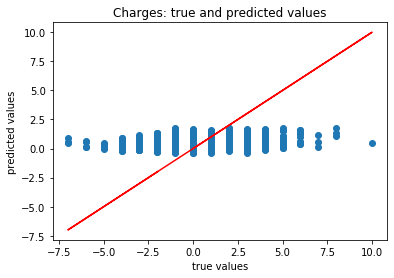

Mean absolute error of the prediction is: 1.3460491465019566
Mean squared error of the prediction is: 3.067312979641058
Root mean squared error of the prediction is: 1.7513745971781873
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [76]:
y_preds = lasso_cv.predict(HX_test)
plt.scatter(hy_test, y_preds)
plt.plot(hy_test, hy_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds) / y_test)) * 100
    )
)

# These are all pretty bad. Let's go on with Gradient boosting to see if that's better?

In [77]:
XGB = XGBRegressor()

<IPython.core.display.Javascript object>

In [78]:
n_trees = 1000
learning_rate = 2 / n_trees

grid = {
    "gbt__subsample": [0.75, 1.0],
    "gbt__max_features": [0.75, 1.0],
    "gbt__max_depth": [2, 3],
    "gbt__n_estimators": [n_trees],
    "gbt__learning_rate": [learning_rate, 0.001, 0.2],
}

XGB_cv = GridSearchCV(XGB, grid, verbose=1, cv=2)
XGB_cv.fit(X_train, y_train)

print(XGB_cv.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   31.2s finished


{'gbt__learning_rate': 0.002, 'gbt__max_depth': 2, 'gbt__max_features': 0.75, 'gbt__n_estimators': 1000, 'gbt__subsample': 0.75}


<IPython.core.display.Javascript object>

In [79]:
train_score = XGB_cv.score(X_train, y_train)
test_score = XGB_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.5817954202191329
test_score: 0.07524662676938154


<IPython.core.display.Javascript object>

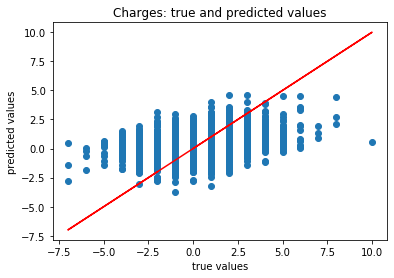

Mean absolute error of the prediction is: 1.3422407312127262
Mean squared error of the prediction is: 2.965164324326957
Root mean squared error of the prediction is: 1.7219652506154
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [80]:
y_preds = XGB_cv.predict(X_test)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds) / y_test)) * 100
    )
)

In [81]:
y_pred = XGB_cv.predict(X_test)
y_pred = y_pred.round()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0   0   0   0   1   0   1   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   1   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   5   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   8  30   7   1   0   0   0   0   0   0   0]
 [  0   0   0   0   1   5  40  46  21   3   0   0   0   0   0   0   0]
 [  0   0   0   0   5   8  65 142  65   8   2   0   0   0   0   0   0]
 [  0   0   0   1   1  23 109 261 162  30   2   0   0   0   0   0   0]
 [  0   0   0   0   2  11 124 419 340  57   4   0   0   0   0   0   0]
 [  0   0   0   0   1  11  63 334 263  78  17   3   0   0   0   0   0]
 [  0   0   0   0   0   8  23 197 188  53  12   2   1   0   0   0   0]
 [  0   0   0   0   0   0   6  69  99  32  18   1   1   0   0   0   0]
 [  0   0   0   0   0   0   2  21  40  19   5   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   9  13  12   2   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   3   3   3   2   1   1   0   0   0   0]
 [  0 

<IPython.core.display.Javascript object>

# Well the gradient boosted regressor seems pretty good. Want to see if I can improve the model

In [82]:
select = SelectKBest(k=5).fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [83]:
features = pd.DataFrame({"Feature": list(X_train.columns), "Scores": select.scores_})
features.sort_values(by="Scores", ascending=False).head(30)

,Feature,Scores
58,Home chanceCreationPositioningClass_Organised,16.646863
51,Home buildUpPlayPositioningClass_Organised,13.688697
26,Away chanceCreationPositioningClass_Organised,13.037344
19,Away buildUpPlayPositioningClass_Organised,9.621335
42,Home defencePressure,8.376348
57,Home chanceCreationShootingClass_Normal,8.370999
56,Home chanceCreationShootingClass_Lots,8.164604
10,Away defencePressure,7.647832
25,Away chanceCreationShootingClass_Normal,6.166801
38,Home buildUpPlayPassing,5.934135


<IPython.core.display.Javascript object>

In [84]:
to_drop = features.sort_values(by="Scores", ascending=False).tail(15)
to_drop.reset_index(drop=True)
to_be = to_drop["Feature"].tolist()
to_be

['Home team_api_id',
 'Home chanceCreationPassing',
 'match_api_id',
 'Home buildUpPlayDribblingClass_Normal',
 'Away year',
 'Away buildUpPlayDribblingClass_Normal',
 'Away chanceCreationPassingClass_Safe',
 'Home chanceCreationPassingClass_Safe',
 'Home chanceCreationCrossing',
 'Away chanceCreationCrossingClass_Lots',
 'Away chanceCreationCrossingClass_Normal',
 'Away team_api_id',
 'Home buildUpPlayDribblingClass_Lots',
 'Away defencePressureClass_Medium',
 'Away buildUpPlaySpeedClass_Slow']

<IPython.core.display.Javascript object>

In [85]:
new_soccer = soccer.drop(columns=to_be)
new_soccer

,Away id,Away team_fifa_api_id,Away buildUpPlaySpeed,Away buildUpPlayPassing,Away chanceCreationPassing,Away chanceCreationCrossing,Away chanceCreationShooting,Away defencePressure,Away defenceAggression,Away defenceTeamWidth,...,Home chanceCreationShootingClass_Normal,Home chanceCreationPositioningClass_Organised,Home defencePressureClass_High,Home defencePressureClass_Medium,Home defenceAggressionClass_Double,Home defenceAggressionClass_Press,Home defenceTeamWidthClass_Normal,Home defenceTeamWidthClass_Wide,Home defenceDefenderLineClass_Offside Trap,goals
0,319,231,35,40,45,50,45,60,70,70,...,1,1,1,0,0,1,0,1,0,1
1,319,231,35,40,45,50,45,60,70,70,...,1,1,1,0,0,1,0,1,0,2
2,319,231,35,40,45,50,45,60,70,70,...,1,1,1,0,0,1,0,1,0,0
3,319,231,35,40,45,50,45,60,70,70,...,1,1,0,1,0,1,1,0,0,0
4,319,231,35,40,45,50,45,60,70,70,...,1,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18238,1215,898,52,48,39,39,37,40,36,52,...,1,1,0,1,0,1,1,0,0,1
18239,1215,898,52,48,39,39,37,40,36,52,...,1,1,0,1,0,1,1,0,0,1
18240,1215,898,52,48,39,39,37,40,36,52,...,1,1,0,1,0,1,1,0,0,-1
18241,1215,898,52,48,39,39,37,40,36,52,...,1,1,0,1,0,0,1,0,0,1


<IPython.core.display.Javascript object>

In [86]:
n_trees = 1000
learning_rate = 2 / n_trees

grid = {
    "gbt__subsample": [0.75, 1.0],
    "gbt__max_features": [0.75, 1.0],
    "gbt__max_depth": [2, 3],
    "gbt__n_estimators": [n_trees],
    "gbt__learning_rate": [learning_rate, 0.001, 0.2],
}

XGB_cv = GridSearchCV(XGB, grid, verbose=1, cv=2)
XGB_cv.fit(X_train, y_train)

print(XGB_cv.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   31.1s finished


{'gbt__learning_rate': 0.002, 'gbt__max_depth': 2, 'gbt__max_features': 0.75, 'gbt__n_estimators': 1000, 'gbt__subsample': 0.75}


<IPython.core.display.Javascript object>

In [87]:
train_score = XGB_cv.score(X_train, y_train)
test_score = XGB_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.5817954202191329
test_score: 0.07524662676938154


<IPython.core.display.Javascript object>

# ok that's absolute trash. No dropping those columns but both have pretty bad overfitting. I'm gonna try logging 

In [88]:
X = new_soccer.drop(columns="goals")
y = new_soccer["goals"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

<IPython.core.display.Javascript object>

In [89]:
preprocessing = ColumnTransformer(
    [("scale_nums", StandardScaler(), X.columns),], remainder="passthrough"
)

<IPython.core.display.Javascript object>

In [90]:
pipeline = Pipeline([("preprocessing", preprocessing), ("gbt", XGBRegressor()),])

<IPython.core.display.Javascript object>

In [91]:
n_trees = 1000
learning_rate = 2 / n_trees

grid = {
    "gbt__subsample": [0.75, 1.0],
    "gbt__max_features": [0.75, 1.0],
    "gbt__max_depth": [2, 3],
    "gbt__n_estimators": [n_trees],
    "gbt__learning_rate": [learning_rate, 0.001, 0.2],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2)
pipeline_cv.fit(X_train, y_train)

print(pipeline_cv.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.2min finished


{'gbt__learning_rate': 0.2, 'gbt__max_depth': 2, 'gbt__max_features': 0.75, 'gbt__n_estimators': 1000, 'gbt__subsample': 1.0}


<IPython.core.display.Javascript object>

In [93]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.29146654565651986
test_score: 0.15265622862088624


<IPython.core.display.Javascript object>

In [98]:
importance_df = pd.DataFrame()
importance_df["feat"] = X_train.columns
importance_df["importance"] = pipeline_cv.best_estimator_["gbt"].feature_importances_

importance_df = importance_df.sort_values("importance", ascending=False)
importance_df.head()

,feat,importance
18,Away chanceCreationPositioningClass_Organised,0.187113
43,Home chanceCreationPositioningClass_Organised,0.128656
17,Away chanceCreationShootingClass_Normal,0.112149
42,Home chanceCreationShootingClass_Normal,0.098688
14,Away buildUpPlayPositioningClass_Organised,0.062180


<IPython.core.display.Javascript object>

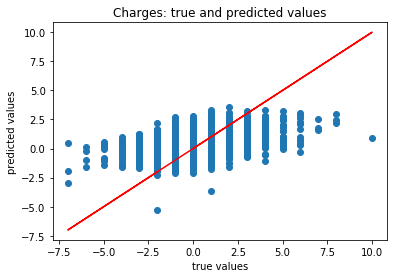

Mean absolute error of the prediction is: 1.271168171640748
Mean squared error of the prediction is: 2.7169552380831656
Root mean squared error of the prediction is: 1.648318912735993
Mean absolute percentage error of the prediction is: inf


<IPython.core.display.Javascript object>

In [100]:
y_preds = pipeline_cv.predict(X_test)
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds) / y_test)) * 100
    )
)

In [101]:
y_pred = pipeline_cv.predict(X_test)
y_pred = y_pred.round()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0   0   0   0   1   1   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   1   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   5   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   7  32   7   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3  30  59  24   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   7  61 150  73   3   0   0   0   0   0   0   0]
 [  0   0   0   0   0   6  84 328 159  11   1   0   0   0   0   0   0]
 [  0   0   0   0   0   7  78 513 322  34   3   0   0   0   0   0   0]
 [  0   0   0   1   0   5  39 347 315  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   1  18 198 205  55   6   1   0   0   0   0   0]
 [  0   0   0   0   0   0   5  72 109  28  12   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2  16  41  24   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   8  16  10   3   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   3   3   4   3   0   0   0   0   0   0]
 [  0 

<IPython.core.display.Javascript object>

# Last model I'm going to be using is Knearestneighbors. If this model is trash then I'm just going to end it there

In [118]:
# Preprocessing aka column transforming
preprocessing = ColumnTransformer(
    [("scale_nums", StandardScaler(), X.columns),], remainder="passthrough"
)
# Modeling pipeline (which will include the preprocessing pipeline)
pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("feat_select", SelectKBest(f_regression)),
        ("regress", KNeighborsRegressor()),
    ]
)

grid = {
    "feat_select__k": range(49, 50),
    "regress__n_neighbors": range(49, 50),
    "regress__weights": ["uniform", "distance"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.2s finished


{'feat_select__k': 49,
 'regress__n_neighbors': 49,
 'regress__weights': 'uniform'}

<IPython.core.display.Javascript object>

In [117]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.11038939676379965
test_score: 0.06130968977133843


<IPython.core.display.Javascript object>

# I have run every model I can think of that would be applicable, but the test and train accuracy are absolutely terrible. I don't think this data is good at predicting goals given the spread of points

In [113]:
y.value_counts()

 0     4628
 1     3862
-1     2862
 2     2557
-2     1483
 3     1182
-3      590
 4      532
-4      214
 5      176
-5       62
 6       46
 7       17
-6       16
 8        7
-7        5
-8        2
 10       1
 9        1
Name: goals, dtype: int64

<IPython.core.display.Javascript object>

In [115]:
print(
    4628
    / (
        3862
        + 2862
        + 2557
        + 1483
        + 1182
        + 590
        + 532
        + 214
        + 176
        + 62
        + 17
        + 16
        + 7
        + 5
        + 2
        + 1
        + 1
    )
)

0.34107156017392587


<IPython.core.display.Javascript object>

In [119]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  goals   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     22.52
Date:                Wed, 22 Apr 2020   Prob (F-statistic):          1.98e-198
Time:                        15:33:22   Log-Likelihood:                -28581.
No. Observations:               14594   AIC:                         5.727e+04
Df Residuals:                   14542   BIC:                         5.766e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.5808      0.335      1.732      0.083      -0.077       1.238
Away id                                           0.0002    3.4e-05      4.758      0.000    9.53e-05       0.000
Away team_fifa_api_id                          2.697e-06   3.98e-07      6.769      0.000    1.92e-06    3.48e-06
Away buildUpPlaySpeed                            -0.0018      0.002     -1.107      0.268      -0.005       0.001
Away buildUpPlayPassing                           0.0062      0.002      3.217      0.001       0.002       0.010
Away chanceCreationPassing                        0.0015      0.002      0.843      0.399      -0.002       0.005
Away chanceCreationCrossing                      -0.0049      0.001     -3.542      0.000      -0.008      -0.002
Away chanceCreationShooting                      -0.0034      0.002     -1.670      0.095      -0.007       0.001
Away defencePressure                             -0.0079      0.002     -4.108      0.000      -0.012      -0.004
Away defenceAggression                           -0.0066      0.002     -3.027      0.002      -0.011      -0.002
Away defenceTeamWidth                             0.0012      0.002      0.553      0.580      -0.003       0.005
Away buildUpPlaySpeedClass_Fast                  -0.0008      0.055     -0.014      0.989      -0.108       0.107
Away buildUpPlayDribblingClass_Lots              -0.2731      0.105     -2.600      0.009      -0.479      -0.067
Away buildUpPlayPassingClass_Mixed               -0.0268      0.074     -0.362      0.718      -0.172       0.119
Away buildUpPlayPassingClass_Short               -0.1359      0.109     -1.251      0.211      -0.349       0.077
Away buildUpPlayPositioningClass_Organised        0.3961      0.065      6.119      0.000       0.269       0.523
Away chanceCreationPassingClass_Risky            -0.1125      0.057     -1.988      0.047      -0.223      -0.002
Away chanceCreationShootingClass_Lots             0.0828      0.121      0.687      0.492      -0.154       0.319
Away chanceCreationShootingClass_Normal           0.3052      0.096      3.191      0.001       0.118       0.493
Away chanceCreationPositioningClass_Organised     0.3663      0.049      7.513      0.000       0.271       0.462
Away defencePressureClass_High                    0.0041      0.090      0.045      0.964      -0.172       0.181
Away defenceAggressionClass_Double                0.1419      0.126      1.127      0.260      -0.105       0.389
Away defenceAggressionClass_Press                 0.0224      0.089      0.251      0.802      -0.153       0.197
Away defenceTeamWidthClass_Normal                -0.0308      0.106     -0.291      0.771      -0.238       0.177
Away 

<IPython.core.display.Javascript object>